### UNIVERSIDAD HEMISFERIOS
#### MODULO APRENDIZAJE AUTOMATICO
#### Integrantes : Danny Diaz  |  Daniel Ortega  | Ruben Tocaín


#### Diagnóstico de Condición de Caja de Engranajes con Señales de Vibración

Este notebook aborda el caso práctico de la Unidad Final, cuyo objetivo es desarrollar un modelo basado en Máquinas de Soporte Vectorial (SVM) para diagnosticar la condición de una caja de engranajes. Las condiciones a identificar son:
1. **Normal**
2. **Picadura en el piñón**
3. **Rotura del diente al 100%**

Se dispone de una base de datos de señales de vibración medidas bajo diferentes velocidades y cargas, y se utilizarán técnicas de procesamiento de señales y machine learning para construir el modelo.

## Objetivos:
1. Importar y procesar la base de datos de señales.
2. Extraer características en los dominios de tiempo y tiempo-frecuencia.
3. Crear conjuntos de entrenamiento y prueba.
4. Escalar las características.
5. Seleccionar características relevantes utilizando un enfoque supervisado.
6. Entrenar un modelo SVM y optimizar hiperparámetros.
7. Evaluar el desempeño del modelo en el conjunto de prueba.

Empecemos con el análisis.


In [3]:
file_path = 'D:/Ruben Tocain/MAESTRIAS/IA INTELIGENCIA ARTIFICIAL/Modulo 5_Aprendizaje Automático/Caso Practico Final/Base_Datos_matlab.mat'

#### 1. Carga y preprocesamiento de la Base de Datos
Este paso incluye la importación de la base de datos en formato .mat y la conversión de los datos en un DataFrame.

In [1]:
# pip install PyWavelets
# conda install pywavelets


from scipy.io import loadmat
import pywt # Librería para wavelets
import numpy as np
from scipy.stats import skew, kurtosis, sem, differential_entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Carga de la base de datos de señales 
# 
data = loadmat('Base_Datos_matlab.mat')

#### 2.Extraccion de caracteristicas de tiempo y tiempo-frecuencia

In [2]:
# Procesamiento de la base de datos para la extracción de características en el dominio del tiempo y tiempo-frecuencia:
# 
def wavelet_features(signal):
    power = []
    for wavelet in ['db7','sym3','coif4','bior3.5','rbio3.5']:
        wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric')
        power.extend([np.square(node.data).mean() for node in wp.get_level(5, 'freq')])        
    return power


def compute_features(signal):
    mean = np.mean(signal)
    var = np.var(signal)
    sk = skew(signal)
    kur = kurtosis(signal)
    rms = np.sqrt(np.mean(signal**2))
    max_val = np.max(signal)
    min_val = np.min(signal)
    std_error = sem(signal)
    ent = differential_entropy(signal)
    std = np.std(signal)
    power = wavelet_features(signal)
    return [mean, var, sk, kur, rms, max_val, min_val, std_error, ent, std, *power]

X_list = []
y_list = []
for condition in [0,3,11]:
    for power in range(3):
        for speed in range(5):
            for repetition in range(10):
                signal = data['CXX'][0][condition][0][power][speed][repetition][:,1]
                features = compute_features(signal)
                X_list.append(features)
                y_list.append(condition)
X = np.array(X_list)
y = np.array(y_list)

#### 3. Creación de grupo de entrenamiento y prueba

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)  


# Verificar las dimensiones
print(f"Train set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Test set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Train set: X_train shape: (315, 170), y_train shape: (315,)
Test set: X_test shape: (135, 170), y_test shape: (135,)


#### 4. Escalar las caracteristicas
El escalado es importante, especialmente para modelos como SVM que son sensibles a la escala de las características.

In [4]:
from sklearn.preprocessing import StandardScaler

# Escalamiento de las características: Normalización
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

#### 5. Selección de Características
Seleccionaremos el 50% de las características usando un método supervisado para simplificar el modelo y potencialmente mejorar el rendimiento.

In [13]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo base (por ejemplo, SVM)
svm = SVC(kernel='linear')  # Usamos un kernel lineal para la importancia de las características

# Crear el selector RFE para seleccionar el 50% de las características
n_features_to_select = int(X_train_scaled.shape[1] * 0.5)
rfe = RFE(estimator=svm, n_features_to_select=n_features_to_select)

# Ajustar el selector a los datos de entrenamiento
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)

# Transformar el conjunto de prueba
X_test_selected = rfe.transform(X_test_scaled)

# Ver las características seleccionadas
print(f"Total de características seleccionadas: {X_train_selected.shape[1]}")

Total de características seleccionadas: 85


In [7]:
X_train_scaled.shape, X_train_selected.shape

((315, 170), (315, 85))

#### 6. Seleccionar los Hiperparámetros del Modelo SVM
Usaremos GridSearchCV para encontrar los mejores hiperparámetros para nuestro modelo SVM.

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Definir el modelo
svm = SVC()

# Parámetros para explorar en la búsqueda en malla
param_grid = {
    'C': [0.1, 1, 10, 100],  # Parámetro de regularización
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Coeficiente para 'rbf', 'poly' y 'sigmoid'
    'kernel': ['rbf', 'poly', 'sigmoid']  # Tipos de kernel a probar
}

# Calcular el número total de combinaciones
num_combinations = len(param_grid['C']) * len(param_grid['gamma']) * len(param_grid['kernel'])
print(f"Total de combinaciones a probar: {num_combinations}")

# Definir la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5)

# Configurar GridSearchCV con más información en verbose
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='accuracy', verbose=3, n_jobs=-1)

# Ajustar el modelo al conjunto de datos de entrenamiento
grid_search.fit(X_train_selected, y_train)

# Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_
# Evaluar el modelo en el conjunto de prueba
accuracy_test = best_svm.score(X_test_selected, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy_test}")

Total de combinaciones a probar: 72
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros encontrados: {'C': 10, 'gamma': 0.1, 'kernel': 'poly'}
Precisión en el conjunto de prueba: 0.9629629629629629


#### 7. Evaluar el Mejor Modelo en el Conjunto de Prueba
Finalmente, evaluaremos el desempeño del modelo seleccionado en el conjunto de prueba.

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Entrenar el modelo con los mejores parámetros obtenidos
best_svm.fit(X_train_selected, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_svm.predict(X_test_selected)

# Evaluar la precisión en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en el conjunto de prueba: {accuracy}")

# Imprimir un reporte de clasificación más detallado (precision, recall, f1-score)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Precisión en el conjunto de prueba: 0.9629629629629629
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           3       0.98      0.91      0.94        45
          11       0.96      1.00      0.98        45

    accuracy                           0.96       135
   macro avg       0.96      0.96      0.96       135
weighted avg       0.96      0.96      0.96       135



Visualizacion de Matriz de Confusion

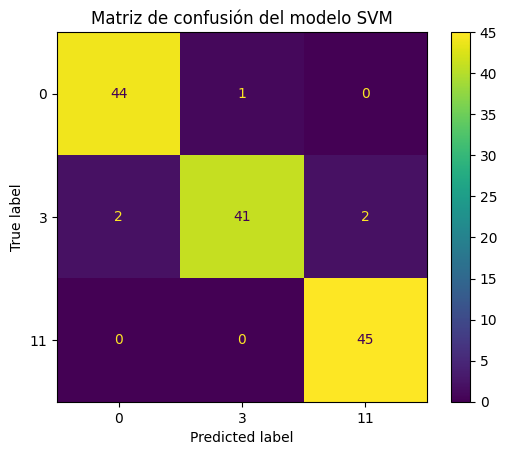

In [16]:
# Visualización de las métricas de desempeño
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_selected, y_test)
plt.title("Matriz de confusión del modelo SVM")
plt.show()

In [8]:

# Paso 4: Escalado de características
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Escalado de características completado.")


Escalado de características completado.


In [9]:

# Paso 5: Selección del 50% de las características usando un enfoque supervisado (por ejemplo, RandomForest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold="median")
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

print("Selección de características completada. Características seleccionadas: ", X_train_selected.shape[1])


Selección de características completada. Características seleccionadas:  85


In [10]:

# Paso 6: Selección de hiperparámetros para el modelo de SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Definir la búsqueda en malla de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train_selected, y_train)

print("Mejores hiperparámetros: ", grid.best_params_)
best_svm = grid.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01

In [11]:

# Paso 7: Evaluar el modelo en el conjunto de prueba
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_svm.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print("Exactitud del modelo en el conjunto de prueba: ", accuracy)
print("Reporte de clasificación: ")
print(classification_report(y_test, y_pred))


Exactitud del modelo en el conjunto de prueba:  0.9629629629629629
Reporte de clasificación: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           3       1.00      0.96      0.98        45
          11       0.96      0.96      0.96        45

    accuracy                           0.96       135
   macro avg       0.96      0.96      0.96       135
weighted avg       0.96      0.96      0.96       135



Visualizacion de Matriz de Confusion

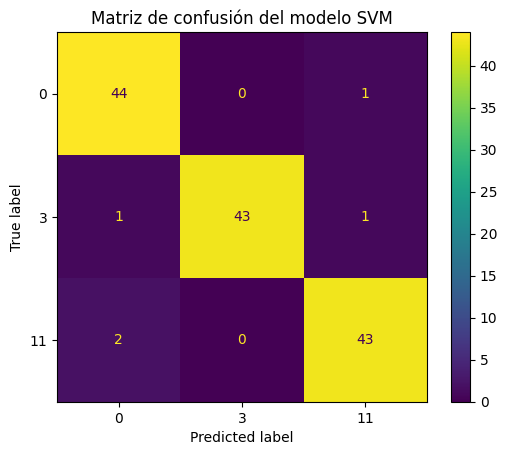

In [12]:
# Visualización de las métricas de desempeño
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_selected, y_test)
plt.title("Matriz de confusión del modelo SVM")
plt.show()